In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
base_path = "/content/drive/MyDrive/FinanceInsight/data/"


In [ ]:
import os

folders = [f.path for f in os.scandir(base_path) if f.is_dir()]

dfs = []

print("Found folders:", folders)

Found folders: ['/content/drive/MyDrive/FinanceInsight/data/2025q1', '/content/drive/MyDrive/FinanceInsight/data/2024q4', '/content/drive/MyDrive/FinanceInsight/data/2025q2']


In [ ]:
!pip install numpy

# =====================================================
# Import libraries
# =====================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

# =====================================================
# Merge all quarterly datasets
# =====================================================

# Find all subfolders inside data (2024q4, 2025q1, 2025q2)
folders = glob.glob(base_path + "*/")

dfs = []

for folder in folders:
    print(f"Processing folder: {folder}")

    sub_path = os.path.join(folder, "sub.txt")
    num_path = os.path.join(folder, "num.txt")

    # Load only if both exist
    if os.path.exists(sub_path) and os.path.exists(num_path):
        sub = pd.read_csv(sub_path, sep='\t', low_memory=False)
        num = pd.read_csv(num_path, sep='\t', low_memory=False)

        # Merge submission info with numeric data
        merged = num.merge(
            sub[['adsh', 'cik', 'name', 'form', 'period', 'filed']],
            on='adsh', how='left'
        )
        merged['source_folder'] = os.path.basename(os.path.normpath(folder))
        dfs.append(merged)
    else:
        print(f"⚠️ Skipped {folder}, missing required files.")

# Combine all quarters
combined_df = pd.concat(dfs, ignore_index=True)
print("✅ Merged shape:", combined_df.shape)
combined_df.head()


Processing folder: /content/drive/MyDrive/FinanceInsight/data/2025q1/
Processing folder: /content/drive/MyDrive/FinanceInsight/data/2024q4/
Processing folder: /content/drive/MyDrive/FinanceInsight/data/2025q2/
✅ Merged shape: (10773559, 16)


,adsh,tag,version,ddate,qtrs,uom,segments,coreg,value,footnote,cik,name,form,period,filed,source_folder
0,0000070145-25-000007,IncreaseDecreaseInAccountsPayableTrade,us-gaap/2024,20241231,1,USD,NaN,NaN,9703000.0,NaN,70145,NATIONAL FUEL GAS CO,10-Q,20241231.0,20250130,2025q1
1,0000351569-25-000006,OtherIntangibleAssetsNet,us-gaap/2024,20241231,0,USD,NaN,NaN,70761000.0,NaN,351569,AMERIS BANCORP,10-K,20241231.0,20250228,2025q1
2,0001555280-25-000102,OtherComprehensiveIncomeLossCashFlowHedgeGainL...,us-gaap/2024,20241231,4,USD,DerivativeInstrumentRisk=NetInvestmentHedging;,NaN,13000000.0,NaN,1555280,ZOETIS INC.,10-K,20241231.0,20250213,2025q1
3,0001558370-25-001154,SellingGeneralAndAdministrativeExpense,us-gaap/2024,20241231,4,USD,BusinessSegments=AllOtherSegments;Consolidatio...,NaN,92526000.0,NaN,1693256,"SELECT WATER SOLUTIONS, INC.",10-K,20241231.0,20250219,2025q1
4,0001013762-25-002376,CancellationOfTreasuryShares,ifrs/2024,20221231,4,USD,ComponentsOfEquity=ReserveOfChangeInValueOfTim...,NaN,NaN,NaN,1450123,JBS S.A.,20-F,20241231.0,20250326,2025q1


In [ ]:
# =====================================================
# 🧹 Basic Cleaning and Filtering
# =====================================================

# Filter to main form types
combined_df = combined_df[combined_df['form'].isin(['10-K', '10-Q', '8-K'])]

# Remove missing or invalid numeric values
combined_df = combined_df.dropna(subset=['value'])

# Convert to numeric safely
combined_df['value'] = pd.to_numeric(combined_df['value'], errors='coerce')

# Drop rows with null numeric values after conversion
combined_df = combined_df.dropna(subset=['value'])

# Keep only key financial tags (for analysis)
key_tags = [
    'Revenues', 'NetIncomeLoss', 'Assets', 'Liabilities',
    'EarningsPerShareBasic', 'CashAndCashEquivalentsAtCarryingValue'
]
combined_df = combined_df[combined_df['tag'].isin(key_tags)]

# Reset index
combined_df = combined_df.reset_index(drop=True)
print("✅ Cleaned shape:", combined_df.shape)
combined_df.head()


✅ Cleaned shape: (452939, 16)


,adsh,tag,version,ddate,qtrs,uom,segments,coreg,value,footnote,cik,name,form,period,filed,source_folder
0,0000097745-25-000010,Assets,us-gaap/2024,20231231,0,USD,BusinessSegments=SpecialtyDiagnostics;Consolid...,NaN,1.150000e+09,NaN,97745,THERMO FISHER SCIENTIFIC INC.,10-K,20241231.0,20250220,2025q1
1,0001273813-25-000011,Revenues,us-gaap/2024,20221231,4,USD,BusinessSegments=InsuranceSegment;Consolidatio...,NaN,9.000000e+06,NaN,1273813,ASSURED GUARANTY LTD,10-K,20241231.0,20250228,2025q1
2,0000950170-25-030989,Revenues,us-gaap/2024,20241231,4,USD,ConcentrationRiskByBenchmark=SalesRevenueNet;C...,NaN,5.616730e+08,NaN,1287865,MEDICAL PROPERTIES TRUST INC,10-K,20241231.0,20250303,2025q1
3,0001213900-25-021742,Revenues,us-gaap/2024,20230930,3,USD,Restatement=RestatementAdjustment;,NaN,5.100000e+05,NaN,1872525,"STRAN & COMPANY, INC.",10-Q,20240930.0,20250307,2025q1
4,0001820566-25-000031,NetIncomeLoss,us-gaap/2024,20231231,4,USD,NaN,NaN,-5.175500e+07,NaN,1820566,INSPIRATO INC,10-K,20241231.0,20250326,2025q1


Unique Companies: 5967
Unique Forms: ['10-K' '10-Q' '8-K']
Time Range: 20241001 to 20250630


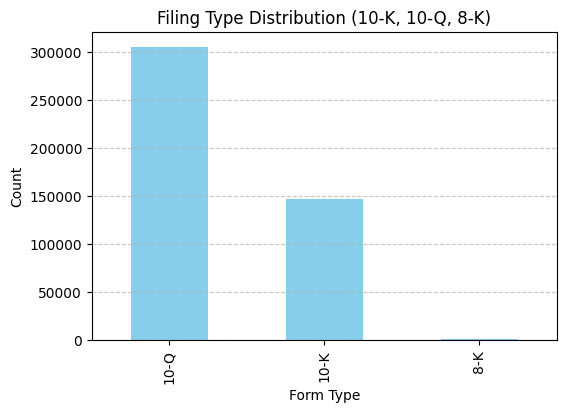

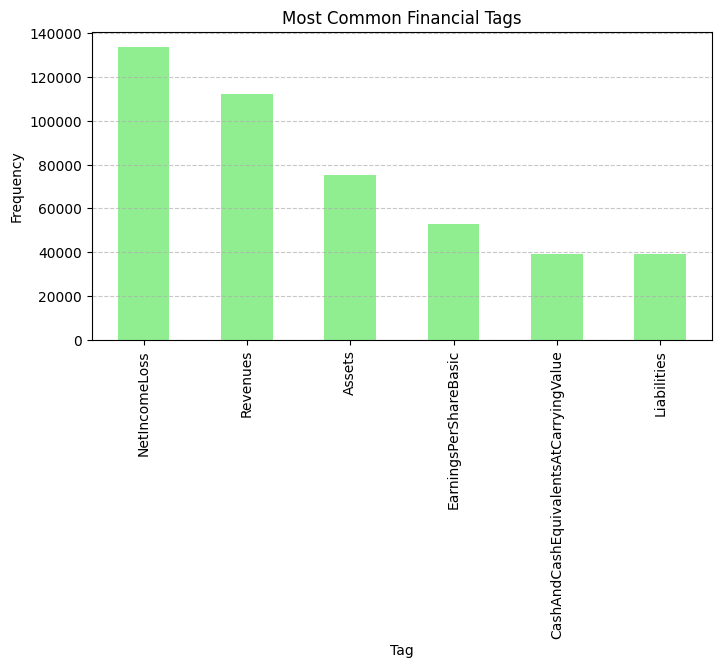

/tmp/ipython-input-1433568560.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_companies.values, y=top_companies.index, palette='cool')


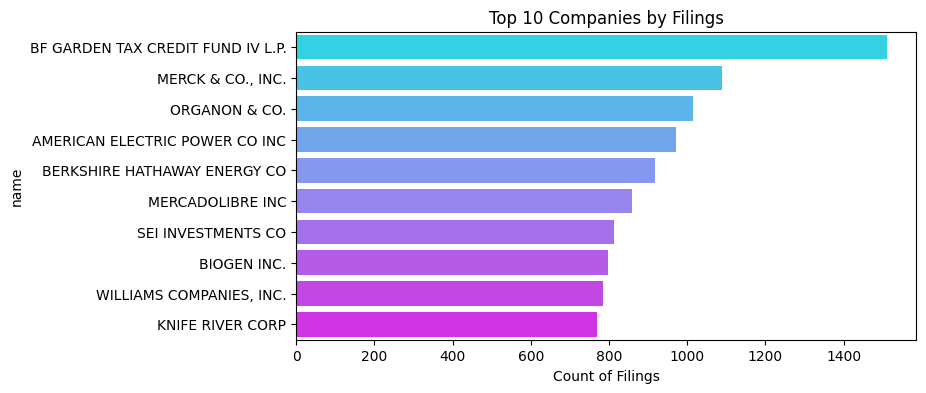

,count,mean,std,min,25%,50%,75%,max
tag,,,,,,,,
Assets,75298.0,1.410038e+10,1.183162e+11,-9.536180e+11,54964000.00,6.150875e+08,3.825758e+09,4.357856e+12
CashAndCashEquivalentsAtCarryingValue,39451.0,9.692322e+08,7.313380e+10,-1.133000e+09,6784000.00,5.372300e+07,2.451650e+08,1.450000e+13
EarningsPerShareBasic,52832.0,7.619276e+03,9.456345e+05,-2.149337e+07,-0.32,1.000000e-02,8.700000e-01,1.084390e+08
Liabilities,39256.0,9.881654e+09,1.100349e+11,-4.138000e+09,10816000.00,1.821845e+08,1.905942e+09,4.255397e+12
NetIncomeLoss,133863.0,1.700905e+08,2.221314e+09,-2.275900e+10,-4379098.50,0.000000e+00,1.861756e+07,4.196700e+11
Revenues,112239.0,2.192023e+09,1.304214e+10,-1.553230e+11,3199092.50,9.311300e+07,7.890000e+08,6.809850e+11


/tmp/ipython-input-1433568560.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  net_income['filed'] = pd.to_datetime(net_income['filed'], errors='coerce')


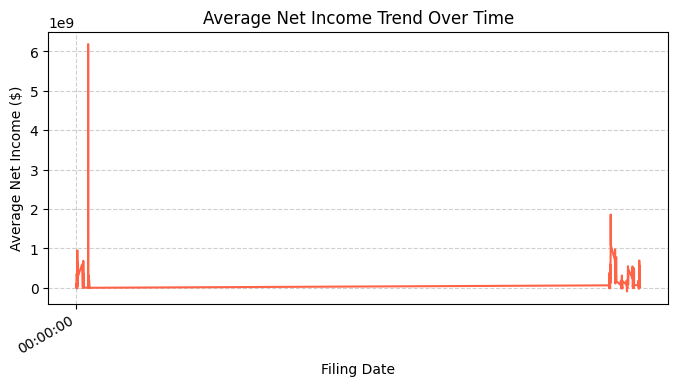

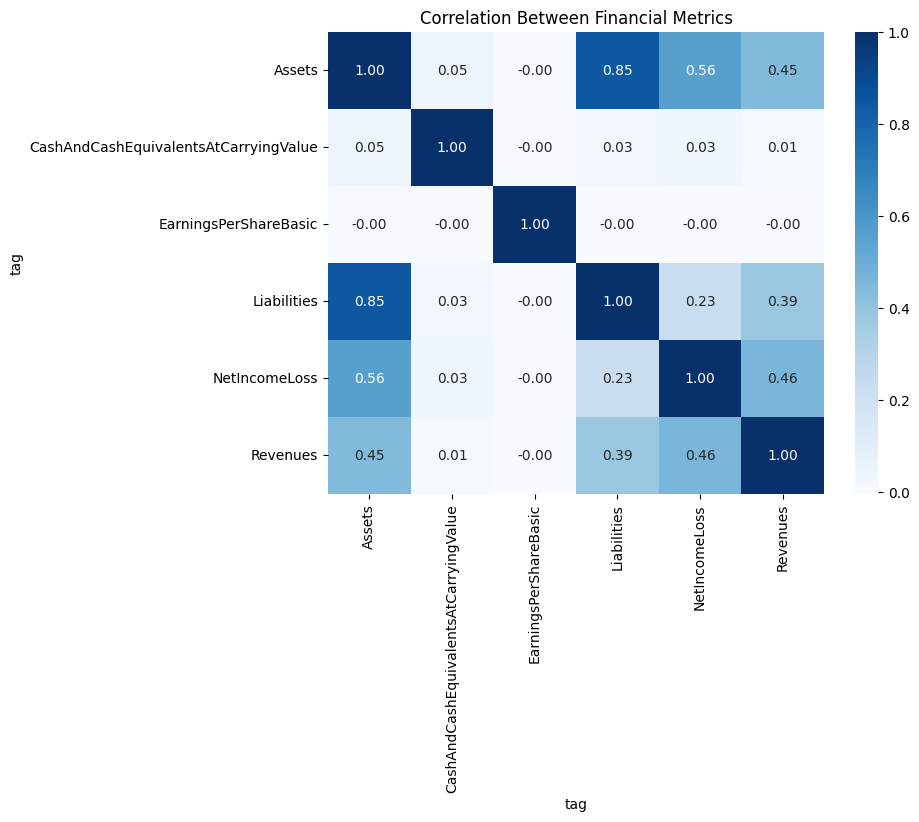

In [ ]:
# =====================================================
# 📈 Basic Overview
# =====================================================
print("Unique Companies:", combined_df['name'].nunique())
print("Unique Forms:", combined_df['form'].unique())
print("Time Range:", combined_df['filed'].min(), "to", combined_df['filed'].max())

# =====================================================
# 🔹 1. Filing Type Distribution
# =====================================================
plt.figure(figsize=(6,4))
combined_df['form'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Filing Type Distribution (10-K, 10-Q, 8-K)')
plt.xlabel('Form Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# =====================================================
# 🔹 2. Most Common Financial Tags
# =====================================================
plt.figure(figsize=(8,4))
combined_df['tag'].value_counts().plot(kind='bar', color='lightgreen')
plt.title('Most Common Financial Tags')
plt.xlabel('Tag')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# =====================================================
# 🔹 3. Top 10 Companies by Number of Filings
# =====================================================
top_companies = combined_df['name'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_companies.values, y=top_companies.index, palette='cool')
plt.title('Top 10 Companies by Filings')
plt.xlabel('Count of Filings')
plt.show()

# =====================================================
# 🔹 4. Summary Statistics of Financial Metrics
# =====================================================
summary_stats = combined_df.groupby('tag')['value'].describe()
display(summary_stats)

# =====================================================
# 🔹 5. Example Trend: Average Net Income over Time
# =====================================================
net_income = combined_df[combined_df['tag'] == 'NetIncomeLoss']
net_income['filed'] = pd.to_datetime(net_income['filed'], errors='coerce')

plt.figure(figsize=(8,4))
net_income.groupby('filed')['value'].mean().plot(color='tomato')
plt.title('Average Net Income Trend Over Time')
plt.xlabel('Filing Date')
plt.ylabel('Average Net Income ($)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# =====================================================
# 🔹 6. Correlation Between Financial Metrics
# =====================================================
pivot = combined_df.pivot_table(
    index='name', columns='tag', values='value', aggfunc='mean'
)
corr = pivot.corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='Blues', fmt=".2f")
plt.title('Correlation Between Financial Metrics')
plt.show()


In [ ]:
combined_df.to_csv("merged_financial_data.csv", index=False)
print("✅ Cleaned & merged data saved to: merged_financial_data.csv")

✅ Cleaned & merged data saved to: merged_financial_data.csv


In [ ]:
# =========================================
# PHASE 2A: TOKENIZATION & POS TAGGING
# Using tag.txt only (financial terminology)
# =========================================

!pip install nltk spacy
!python -m spacy download en_core_web_sm

import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
import spacy

# --- 1️⃣ Setup ---
nltk.download('punkt')
nlp = spacy.load('en_core_web_sm')

# --- 2️⃣ Load SEC tag.txt data ---
folder_path = "/content/drive/MyDrive/FinanceInsight/data/2025q1/"
tag_path = folder_path + "tag.txt"

df_tag = pd.read_csv(tag_path, sep="\t", low_memory=False)

# --- 3️⃣ Select relevant columns & non-empty text definitions ---
df_tag = df_tag[['tag', 'tlabel', 'doc']].dropna().reset_index(drop=True)

# We'll use only the 'doc' column (natural definitions of financial tags)
texts = df_tag['doc'].dropna().tolist()

print(f"✅ Loaded {len(texts)} financial definitions from tag.txt")

# --- 4️⃣ Text Cleaning Function ---
def clean_text(t):
    t = re.sub(r'\s+', ' ', str(t))
    t = re.sub(r'[^a-zA-Z0-9%$.,-]', ' ', t)
    return t.strip().lower()

# --- 5️⃣ Tokenization + POS Tagging ---
records = []
for txt in texts[:1000]:  # optional limit for faster run
    clean = clean_text(txt)
    doc = nlp(clean)
    tokens = [token.text for token in doc]
    pos = [token.pos_ for token in doc]
    lemmas = [token.lemma_ for token in doc]
    records.append({
        'sentence': clean[:300],
        'tokens': tokens[:30],
        'pos_tags': pos[:30],
        'lemmas': lemmas[:30]
    })

# --- 6️⃣ Save Tokenized Output ---
df_out = pd.DataFrame(records)
df_out.to_csv("tokenized_financial_terms.csv", index=False)
print("✅ Saved:", "tokenized_financial_terms.csv", f"({len(df_out)} rows)")

display(df_out.head())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ Loaded 82954 financial definitions from tag.txt
✅ Saved: tokenized_financial_terms.csv (1000 rows)


,sentence,tokens,pos_tags,lemmas
0,"contract with customer, liability, net of disc...","[contract, with, customer, ,, liability, ,, ne...","[NOUN, ADP, NOUN, PUNCT, NOUN, PUNCT, NOUN, AD...","[contract, with, customer, ,, liability, ,, ne..."
1,increase decrease in other operating capital,"[increase, , decrease, , in, other, operatin...","[VERB, SPACE, NOUN, SPACE, ADP, ADJ, NOUN, NOUN]","[increase, , decrease, , in, other, operatin..."
2,"other comprehensive income loss , unrecognize...","[other, comprehensive, income, , loss, ,, unr...","[ADJ, ADJ, NOUN, SPACE, NOUN, PUNCT, ADJ, NOUN...","[other, comprehensive, income, , loss, ,, unr..."
3,"other comprehensive income loss , unrecognize...","[other, comprehensive, income, , loss, ,, unr...","[ADJ, ADJ, NOUN, SPACE, NOUN, PUNCT, ADJ, NOUN...","[other, comprehensive, income, , loss, ,, unr..."
4,proceeds from tenant incentive cash received o...,"[proceeds, from, tenant, incentive, cash, rece...","[NOUN, ADP, PROPN, NOUN, NOUN, VERB, ADP, NOUN...","[proceed, from, tenant, incentive, cash, recei..."


In [ ]:
# =========================================
#  PHASE 2B: FETCH 10-K / 10-Q TEXT
# =========================================
import time
!pip install requests beautifulsoup4 tqdm

import requests, re, pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

headers = {"User-Agent": "FinanceInsightProject/1.0 (your_email@example.com)"}

CIKs = ["0000320193","0000789019","0001018724","0001652044","0000051143","0001067983","0001318605",
    "0001090872","0000200406","0000019617","0000078003","0000066740","0000072971","0001104657",
    "0000045012","0000104169","0000102909","0000021344","0000320187","0000874716"]
# --- 2️⃣ Fetch company submission metadata ---
all_records = []
for CIK in CIKs:
  sub_url = f"https://data.sec.gov/submissions/CIK{CIK}.json"
  data = requests.get(sub_url, headers=headers).json()

  # --- 3️⃣ Collect 10-K / 10-Q filings with full URLs ---
  records = []
  for i, form in enumerate(data['filings']['recent']['form']):
      if form in ['10-K', '10-Q']:
          accession = data['filings']['recent']['accessionNumber'][i].replace('-', '')
          filing_date = data['filings']['recent']['filingDate'][i]
          primary_doc = data['filings']['recent']['primaryDocument'][i]
          # This gives the actual filing .htm file, not the index
          filing_url = f"https://www.sec.gov/Archives/edgar/data/{int(CIK)}/{accession}/{primary_doc}"
          records.append((form, filing_date, filing_url))

  print(f"Found {len(records)} filings for CIK {CIK}")
  all_records.extend(records)


def extract_sections(html_text):
    soup = BeautifulSoup(html_text, "html.parser")
    text = soup.get_text(separator=" ")

    # Normalize spaces and case
    text = re.sub(r'\s+', ' ', text)
    text = text.replace('\xa0', ' ')

    # More flexible patterns (allow :, ;, or - after ITEM number)
    patterns = {
        "BusinessOverview": r'ITEM\s*1[\.:;\- ]+\s*BUSINESS.*?(?=ITEM\s*1A[\.:;\- ]+|ITEM\s*2[\.:;\- ]+)',
        "RiskFactors": r'ITEM\s*1A[\.:;\- ]+\s*RISK.*?(?=ITEM\s*1B[\.:;\- ]+|ITEM\s*2[\.:;\- ]+)',
        "MD&A": r'ITEM\s*(7|2)[\.:;\- ]+\s*MANAGEMENT.*?(?=ITEM\s*(8|3)[\.:;\- ]+)',
        "FinancialStatements": r'ITEM\s*(8|3)[\.:;\- ]+\s*FINANCIAL.*?(?=ITEM\s*(9|4)[\.:;\- ]+)'
    }

    sections = {}
    for name, pat in patterns.items():
        m = re.search(pat, text, re.DOTALL | re.IGNORECASE)
        if m:
            sections[name] = m.group(0).strip()

    # Combine whatever was found
    if sections:
        combined = "\n\n".join([f"==== {k} ====\n{v}" for k,v in sections.items()])
        return combined
    return None


# --- 5️⃣ Download and Extract MD&A Sections ---
filing_text_records = []
for form, date, url in tqdm(all_records[:]):
    try:
        html = requests.get(url, headers=headers).text
        combined_sections = extract_sections(html)
        if combined_sections:
            filing_text_records.append({
                'cik': url.split('/')[-3], # Extract CIK from URL
                'form': form,
                'filed': date,
                'filing_url': url,
                'sections_text': combined_sections[:]
            })
            time.sleep(0.5)
    except Exception as e:
        print(f"⚠️ Error with {url}: {e}")

# --- 6️⃣ Save as CSV ---
df_filings_text = pd.DataFrame(filing_text_records)
if not df_filings_text.empty:
    df_filings_text.to_csv("filings_text_sections.csv", index=False)
    print("✅ Saved:", "filings_text_sections.csv", f"({len(df_filings_text)} rows)")
else:
    print("⚠️ Text extracted — check filing URLs.")

display(df_filings_text.head())

Found 43 filings for CIK 0000320193
Found 25 filings for CIK 0000789019
Found 26 filings for CIK 0001018724
Found 14 filings for CIK 0001652044
Found 26 filings for CIK 0000051143
Found 39 filings for CIK 0001067983
Found 33 filings for CIK 0001318605
Found 41 filings for CIK 0001090872
Found 36 filings for CIK 0000200406
Found 4 filings for CIK 0000019617
Found 21 filings for CIK 0000078003
Found 32 filings for CIK 0000066740
Found 9 filings for CIK 0000072971
Found 37 filings for CIK 0001104657
Found 32 filings for CIK 0000045012
Found 15 filings for CIK 0000104169
Found 0 filings for CIK 0000102909
Found 35 filings for CIK 0000021344
Found 45 filings for CIK 0000320187
Found 47 filings for CIK 0000874716


100%|██████████| 560/560 [21:18<00:00,  2.28s/it]


✅ Saved: filings_text_sections.csv (540 rows)


,cik,form,filed,filing_url,sections_text
0,320193,10-Q,2025-08-01,https://www.sec.gov/Archives/edgar/data/320193...,==== RiskFactors ====\nItem 1A. Risk Factors 2...
1,320193,10-Q,2025-05-02,https://www.sec.gov/Archives/edgar/data/320193...,==== RiskFactors ====\nItem 1A. Risk Factors 2...
2,320193,10-Q,2025-01-31,https://www.sec.gov/Archives/edgar/data/320193...,==== RiskFactors ====\nItem 1A. Risk Factors 1...
3,320193,10-K,2024-11-01,https://www.sec.gov/Archives/edgar/data/320193...,==== BusinessOverview ====\nItem 1. Business 1...
4,320193,10-Q,2024-08-02,https://www.sec.gov/Archives/edgar/data/320193...,==== RiskFactors ====\nItem 1A. Risk Factors 1...


In [ ]:
# ---------------------------
# PHASE 3: Preprocess, EDA, Augmentation, Merge w/ Numeric, Weak-label NER
# ---------------------------

!pip install -q nltk spacy textblob tqdm rapidfuzz
!python -m spacy download en_core_web_sm

import re, time, json, math, random
import pandas as pd
import numpy as np
import spacy
from tqdm import tqdm
from textblob import TextBlob
from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

nlp = spacy.load("en_core_web_sm")

# ---------- Config ----------
LIMIT_FILINGS = None
TERM_LIMIT = None

# Expanded CIK list (used only if available in filings)
EXPANDED_CIKs = [
    "0000320193","0000789019","0001018724","0001652044","0000051143","0001067983","0001318605",
    "0001090872","0000200406","0000019617","0000078003","0000066740","0000072971","0001104657",
    "0000045012","0000104169","0000102909","0000021344","0000320187","0000874716"
]

# ---------- Filepaths ----------
TOKEN_TERMS_PATH = "/content/tokenized_financial_terms.csv"
FILINGS_TEXT_PATH = "/content/filings_text_sections.csv"
NUMERIC_PATH = "/content/merged_financial_data.csv"

# ---------- 1. Load inputs ----------
terms_df = pd.read_csv(TOKEN_TERMS_PATH, low_memory=False)
filings_df = pd.read_csv(FILINGS_TEXT_PATH, low_memory=False)
num_df = pd.read_csv(NUMERIC_PATH, low_memory=False)
print(f"Loaded: {terms_df.shape} term rows; {filings_df.shape} filing rows; {num_df.shape} numeric rows")

# ---------- 2. Filter filings safely ----------
if 'cik' in filings_df.columns:
    expanded_present = filings_df['cik'].astype(str).isin(EXPANDED_CIKs)
    if expanded_present.any():
        filings_df = filings_df[expanded_present]
        print(f"✅ Using expanded CIK subset: {filings_df.shape} filings")
    else:
        print("⚠️ None of expanded CIKs found in filings_text_sections.csv → using all filings")
else:
    print("⚠️ No 'cik' column found in filings, using all data")



# optional limit for speed during dev
if LIMIT_FILINGS:
    filings_df = filings_df.iloc[:LIMIT_FILINGS].copy()

# ---------- 3. Preprocess functions ----------
def clean_text(t):
    if not isinstance(t,str): return ""
    # keep original_text separately (we will keep original for span indices)
    s = t
    # normalize whitespace & convert special NBSP
    s = s.replace('\xa0',' ')
    s = re.sub(r'[\r\n\t]+', ' ', s)
    # Replace weird characters but keep $, %, ., , - and parentheses for negative numbers
    s = re.sub(r'[^A-Za-z0-9\$\%\.\,\-\(\)/:&\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# detect financial jargon - extended regex
FIN_TERM_RE = re.compile(
    r'\b(p\/e|pe ratio|eps|ebitda|ebit|revenue|net\s*income|cash\s*flow|debt\s*ratio|operating\s*margin|gross\s*margin|free\s*cash\s*flow)\b',
    re.IGNORECASE
)

# ticker patterns (NYSE/NASDAQ style) - heuristic: look for "(TICKER)" or "NYSE: TICKER", "NASDAQ: TICKER"
def extract_tickers(text):
    tickers = set()
    # (AAPL)
    for m in re.finditer(r'\(([A-Z]{2,5})\)', text):
        tickers.add(m.group(1))
    # NYSE: TICKER or NASDAQ: TICKER
    for m in re.finditer(r'(?:NYSE|NASDAQ|AMEX)[:\s]+([A-Z]{1,5})', text, flags=re.IGNORECASE):
        tickers.add(m.group(1).upper())
    return list(tickers)

# tokenize + pos via spacy pipeline (fast using pipe)
def spacy_tokenize_pos(texts):
    toks, poses = [], []
    for doc in nlp.pipe(texts, disable=['ner'], batch_size=64):
        toks.append([t.text for t in doc])
        poses.append([t.pos_ for t in doc])
    return toks, poses

# augmentation: synonym replacement (skip finance jargon tokens)
def synonym_replace(sentence, n=2):
    words = sentence.split()
    if len(words) < 3:
        return sentence
    attempts = 0
    for _ in range(n):
        attempts += 1
        idx = random.randrange(len(words))
        candidate = words[idx]
        # skip if punctuation or finance keywords
        if FIN_TERM_RE.search(candidate) or not candidate.isalpha():
            continue
        syns = wordnet.synsets(candidate)
        if not syns:
            continue
        lemmas = [l.name().replace('_',' ') for s in syns for l in s.lemmas() if l.name().lower()!=candidate.lower()]
        if not lemmas:
            continue
        new_word = random.choice(lemmas)
        words[idx] = new_word
        if attempts > 10:
            break
    return " ".join(words)

# back-translation via TextBlob (may be slow/unreliable; wrapped in try/except)
def back_translate(sentence, src='en', mid='fr'):
    try:
        tb = TextBlob(sentence)
        return str(tb.translate(to=mid).translate(to=src))
    except Exception:
        return sentence

# monetary parsing (improved): handles parentheses, $ signs, million/billion, negatives
def parse_money_amounts(text):
    if not isinstance(text,str): return []
    t = text
    t = t.replace(',', '')
    # handle parentheses for negative values: "(25,000)" -> -25000
    # Patterns: $25 million, 25 million dollars, (25,000), 25m, 2.5 billion, USD 25,000
    patterns = [
        r'(\(|)?(\$|USD\s*)?([0-9]+(?:\.[0-9]+)?)(\s*(million|billion|thousand|m|bn|k))?(\))?',
        r'([0-9]+(?:\.[0-9]+)?)\s*(million|billion|thousand|m|bn|k)\s*(dollars)?'
    ]
    matches = []
    for pat in patterns:
        for m in re.finditer(pat, t, flags=re.IGNORECASE):
            groups = m.groups()
            # several groups; attempt to extract number and multiplier
            # find the numeric capture - search group for digits
            num = None
            mul = None
            for g in groups[::-1]:
                if isinstance(g,str) and re.match(r'^[0-9]+(\.[0-9]+)?$', g):
                    num = float(g)
                    break
            # multiplier detection in groups
            mul = ''
            for g in groups:
                if isinstance(g,str) and g:
                    if re.search(r'million|m\b', g, re.IGNORECASE):
                        mul = 'million'
                    if re.search(r'billion|bn|b\b', g, re.IGNORECASE):
                        mul = 'billion'
                    if re.search(r'thousand|k\b', g, re.IGNORECASE):
                        mul = 'thousand'
            if num is None:
                continue
            scale = 1.0
            if mul == 'million':
                scale = 1e6
            elif mul == 'billion':
                scale = 1e9
            elif mul == 'thousand':
                scale = 1e3
            value = num * scale
            # negative?
            start, end = m.start(), m.end()
            # if parentheses match group indicates parentheses, treat negative
            if '(' in m.group(0) and ')' in m.group(0):
                value = -value
            matches.append((m.group(0), value, start, end))
    # dedupe by span
    seen=set(); out=[]
    for o,v,s,e in matches:
        if (s,e) not in seen:
            out.append((o,v,s,e)); seen.add((s,e))
    return out

# ---------- 4. Build corpus DF with metadata ----------
# Convert terms_df sentences -> text rows with no cik/filed metadata (domain rows)
terms_only = terms_df.rename(columns={'sentence':'text'})[['text']].dropna().reset_index(drop=True)
if TERM_LIMIT:
    terms_only = terms_only.iloc[:TERM_LIMIT]

# filings: rename sections_text -> raw_text
filings = filings_df.copy()
filings['raw_text'] = filings['sections_text'].astype(str)
# keep columns: cik, form, filed, filing_url, raw_text
filings = filings[['cik','form','filed','filing_url','raw_text']].copy()

# preserve filing dates as datetime
filings['filed'] = pd.to_datetime(filings['filed'], errors='coerce')

# Compose combined corpus
terms_only['cik'] = np.nan
terms_only['form'] = np.nan
terms_only['filed'] = pd.NaT
terms_only['filing_url'] = np.nan
terms_only = terms_only[['cik','form','filed','filing_url','text']]

filings_rows = filings.rename(columns={'raw_text':'text'})[['cik','form','filed','filing_url','text']]

combined = pd.concat([filings_rows, terms_only], ignore_index=True, sort=False)
combined = combined.dropna(subset=['text']).reset_index(drop=True)
print("Combined corpus rows:", combined.shape)

# ---------- 5. Clean + Tokenize + POS ----------
combined['clean_text'] = combined['text'].apply(clean_text)

# Tokenize and POS in batches (faster)
texts_to_process = combined['clean_text'].tolist()
toks, poses = spacy_tokenize_pos(texts_to_process)
combined['tokens'] = toks
combined['pos_tags'] = poses

# ---------- 6. Financial jargon & tickers ----------
combined['contains_fin_term'] = combined['clean_text'].apply(lambda x: bool(FIN_TERM_RE.search(x)))
combined['tickers'] = combined['text'].apply(lambda x: extract_tickers(str(x)))

# ---------- 7. Simple EDA ----------
print("\nEDA summary:")
print(" - total rows:", len(combined))
print(" - rows with financial jargon:", combined['contains_fin_term'].sum())
avg_words = combined['clean_text'].apply(lambda s: len(s.split())).mean()
print(" - avg words per row:", round(avg_words,2))

# show top frequent words (small sample)
from collections import Counter
word_counts = Counter()
for txt in combined['clean_text'].dropna().sample(min(200, len(combined))):
    word_counts.update(txt.split())
print(" - top words sample:", word_counts.most_common(10))

# ---------- 8. Augmentation ----------
# create two augmented columns (synonym + back translate)
combined['aug_synonym'] = combined['clean_text'].apply(lambda x: synonym_replace(x, n=2))
# back-translation can be slow; run only for filings (not for terms-only) optionally
def safe_backtrans(row):
    try:
        return back_translate(row) if len(row.split())>3 else row
    except Exception:
        return row

combined['aug_backtrans'] = combined['clean_text'].apply(lambda x: safe_backtrans(x))

# ---------- 9. Save preprocessed texts (preserve metadata) ----------
combined.to_csv("preprocessed_financial_texts.csv", index=False)
print("Saved preprocessed_financial_texts.csv ->", combined.shape)

# ---------- 10. Merge with numeric data ----------
# Ensure numeric 'filed' col is datetime - Use errors='coerce' to turn invalid parsing into NaT
num = num_df.copy()
if 'filed' in num.columns:
    # Attempt to convert to datetime using a specific format if known, otherwise rely on pandas inference
    try:
        num['filed'] = pd.to_datetime(num['filed'], format='%Y%m%d', errors='coerce')
    except ValueError:
        num['filed'] = pd.to_datetime(num['filed'], errors='coerce')

# pivot numeric by (cik,filed)
key_tags = ['Revenues','NetIncomeLoss','Assets','Liabilities','EarningsPerShareBasic','CashAndCashEquivalentsAtCarryingValue']
num_sub = num[num['tag'].isin(key_tags)].copy()

numeric_pivot = num_sub.pivot_table(index=['cik','filed'], columns='tag', values='value', aggfunc='first').reset_index()

# Convert 'cik' columns to the same data type before merging
combined_to_merge = combined.dropna(subset=['cik']).copy() # Drop rows with NaN CIKs
combined_to_merge['cik'] = combined_to_merge['cik'].astype('int64')
numeric_pivot['cik'] = numeric_pivot['cik'].astype('int64')

print("combined_to_merge['cik'] dtype:", combined_to_merge['cik'].dtype)
print("numeric_pivot['cik'] dtype:", numeric_pivot['cik'].dtype)

# exact merge first
merged_exact = combined_to_merge.merge(numeric_pivot, on=['cik','filed'], how='left', suffixes=('','_num'))

# for rows missing numeric values, do nearest-asof merge (within tolerance)
# Ensure both dataframes are sorted by 'cik' and 'filed' before merge_asof
numeric_sorted = numeric_pivot.sort_values(by=['cik', 'filed']).dropna(subset=['filed']).copy()
filings_sorted = combined_to_merge.sort_values(by=['cik', 'filed']).dropna(subset=['filed']).copy() # Use combined_to_merge

print("filings_sorted head before merge_asof:\n", filings_sorted[['cik','filed']].head())
print("numeric_sorted head before merge_asof:\n", numeric_sorted[['cik','filed']].head())
print("filings_sorted dtypes before merge_asof:\n", filings_sorted[['cik','filed']].dtypes)
print("numeric_sorted dtypes before merge_asof:\n", numeric_sorted[['cik','filed']].dtypes)

# Alternative merge approach: merge on cik and then use merge_asof on 'filed' within groups
merged_asof_alt = pd.DataFrame()
if not filings_sorted.empty and not numeric_sorted.empty:
    # Group by CIK and perform merge_asof within each group
    for cik, filings_group in filings_sorted.groupby('cik'):
        numeric_group = numeric_sorted[numeric_sorted['cik'] == cik]
        if not numeric_group.empty:
            # Ensure filings_group is sorted by 'filed' before merge_asof
            filings_group = filings_group.sort_values(by='filed')
            merged_group = pd.merge_asof(filings_group, numeric_group, on='filed', by='cik',
                                         direction='nearest', tolerance=pd.Timedelta(days=120))
            merged_asof_alt = pd.concat([merged_asof_alt, merged_group], ignore_index=True)

    # merge back results: prefer exact matches; fill missing numeric columns from asof
    merged = merged_exact.merge(merged_asof_alt[['cik','filed'] + key_tags], on=['cik','filed'], how='left', suffixes=('','_asof'))
    for tag in key_tags:
        if tag + '_asof' in merged.columns:
            merged[tag] = merged[tag].combine_first(merged[tag + '_asof'])
            merged.drop(columns=[tag + '_asof'], inplace=True)
else:
    merged = merged_exact


merged.to_csv("combined_numeric_text.csv", index=False)
print("Saved combined_numeric_text.csv ->", merged.shape)

# ---------- 11. Weak-labeling: match money mentions to numeric tags ----------
def match_money_to_tags(text_row, row_numeric_dict, tol_frac=0.1):
    """Return list of (start,end,label) for entities if matched."""
    if not isinstance(text_row,str): return []
    mentions = parse_money_amounts(text_row)
    entities = []
    for orig, val, s, e in mentions:
        best_tag, best_diff = None, float('inf')
        for tag, numval in row_numeric_dict.items():
            if numval is None or (isinstance(numval,float) and math.isnan(numval)): continue
            try:
                numval_f = float(numval)
            except:
                continue
            if abs(numval_f) < 1e-6:
                continue
            diff = abs(val - numval_f) / (abs(numval_f) + 1e-9)
            if diff < best_diff:
                best_diff = diff; best_tag = tag
        if best_tag and best_diff < tol_frac:
            # label money span
            entities.append((s, e, "MONEY"))
            # label metric approximate span (we'll try to find metric word in +/-80 chars)
            start_metric = max(0, s-80)
            end_metric = min(len(text_row), e+80)
            entities.append((start_metric, end_metric, f"METRIC_{best_tag}"))
    return entities

ner_examples = []
count = 0
for idx, row in tqdm(merged[merged['text'].notna()].iterrows(), total=merged['text'].notna().sum()):
    text_orig = str(row['text'])
    # build numeric dict
    numeric_dict = {tag: row.get(tag, None) for tag in key_tags}
    ents = match_money_to_tags(text_orig, numeric_dict, tol_frac=0.10)
    if ents:
        ner_examples.append({"text": text_orig, "entities": ents, "meta": {"cik": row.get('cik'), "filed": str(row.get('filed'))}})
        count += 1

print("Auto-labeled NER examples:", count)
# ---------- 11B. Weak-labeling using dslim/bert-base-NER ----------
from transformers import pipeline
ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

additional_ner_examples = []
for idx, row in tqdm(merged[merged['text'].notna()].iterrows(), total=merged['text'].notna().sum()):
    text = str(row['text'])[:2000]  # truncate for efficiency
    ents = []
    for ent in ner_pipe(text):
        ents.append([ent['start'], ent['end'], ent['entity_group']])
    if ents:
        additional_ner_examples.append({
            "text": text,
            "entities": ents,
            "meta": {"cik": row.get('cik'), "filed": str(row.get('filed'))}
        })

print("Added weak labels from BERT:", len(additional_ner_examples))

# Merge rule-based + BERT-based examples
all_ner_examples = ner_examples + additional_ner_examples

with open("ner_training_data.jsonl", "w", encoding="utf8") as f:
    for ex in all_ner_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")

print("✅ Saved combined weak-labeled ner_training_data.jsonl:", len(all_ner_examples))


# ---------- 12. Save ner jsonl ----------
with open("ner_training_data.jsonl","w",encoding="utf8") as f:
    for ex in ner_examples:
        f.write(json.dumps(ex, ensure_ascii=False) + "\n")
print("Saved ner_training_data.jsonl (auto-labeled):", len(ner_examples))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 48.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Loaded: (1000, 4) term rows; (540, 5) filing rows; (452939, 16) numeric rows
⚠️ None of expanded CIKs found in filings_text_sections.csv → using all filings
Combined corpus rows: (1540, 5)

EDA summary:
 - total rows: 1540
 - rows with financial jargon: 132
 - avg words per row: 678.46
 - top words sample: [('the', 11270), ('of', 8547), ('and', 8126), ('in', 4997), ('to', 4851), ('for', 2355), ('a', 2341), ('The', 2328), ('Company', 2128), (')', 1831)]
Saved preprocessed_financial_texts.csv -> (1540, 12)
combined_to_merge['cik'] dtype: int64
numeric_pivot['cik'] dtype: int64
filings_sorted head before merge_asof:
        cik      filed
266  19617 2024-10-30
265  19617 2025-02-14
264  19617 2025-05-01
263  19617 2025-08-05
447  21344 2017-04-27
numeric_sorted head before merge_asof:
 tag   cik      filed
0    1750 2025-01-08
1    1750 2025-03-28
2    1800 2024-10-31
3    1800 2025-02-21
4    1800 2025-04-30
filings_sorted dtypes before merge_asof:
 cik               int64
filed    datet

100%|██████████| 540/540 [00:03<00:00, 158.82it/s]


Auto-labeled NER examples: 27


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
100%|██████████| 540/540 [04:41<00:00,  1.92it/s]

Added weak labels from BERT: 540
✅ Saved combined weak-labeled ner_training_data.jsonl: 567
Saved ner_training_data.jsonl (auto-labeled): 27


In [ ]:
import json

path = "/content/ner_training_data.jsonl"

with open(path, "r", encoding="utf8") as f:
    data = [json.loads(line) for line in f]

print("Total examples:", len(data))
print("\nSample entry:\n", json.dumps(data[0], indent=2))


Total examples: 27

Sample entry:
 {
  "text": "==== RiskFactors ====\nItem 1A. Risk Factors 19\n\n==== MD&A ====\nItem 2. Management\u2019s Discussion and Analysis of Financial Condition and Results of Operations 12",
  "entities": [
    [
      68,
      69,
      "MONEY"
    ],
    [
      0,
      149,
      "METRIC_EarningsPerShareBasic"
    ]
  ],
  "meta": {
    "cik": 320193,
    "filed": "2025-01-31 00:00:00"
  }
}


In [ ]:
# ===========================
# PHASE 7A: Weak-Label Expansion using dslim/bert-base-NER
# ===========================

!pip install -q transformers tqdm

import json, random
from tqdm import tqdm
from transformers import pipeline

# ---------- 1️⃣ Load base labeled data ----------
base_path = "/content/ner_training_data.jsonl"
with open(base_path, "r", encoding="utf8") as f:
    base_examples = [json.loads(line) for line in f]

print(f"Loaded {len(base_examples)} labeled examples")

# ---------- 2️⃣ Generate or load unlabeled text ----------
financial_samples = [
    "Apple reported a net income of $2.5 billion in Q4 2024.",
    "Microsoft’s total assets increased to $410 billion last year.",
    "Amazon posted basic earnings per share of $3.25.",
    "Tesla announced cash equivalents of $23 billion in the last quarter.",
    "Netflix’s operating expenses rose by 12% compared to previous year.",
    "Meta recorded total liabilities of $95 billion.",
    "Alphabet reported an EPS growth of 15% year-over-year.",
    "Johnson & Johnson’s revenue reached $82 billion in FY2024.",
    "Pfizer saw net income loss of $1.8 billion due to R&D costs.",
    "Goldman Sachs reported assets under management of $2 trillion.",
    "Intel announced total revenues of $54 billion for fiscal year 2024.",
    "IBM’s gross margin improved to 49% in Q3 2024.",
    "Coca-Cola’s earnings per share grew to $2.18 in FY2023.",
    "PepsiCo reported cash flow from operations of $9.4 billion.",
    "NVIDIA’s market capitalization exceeded $1 trillion in June 2024.",
    "Oracle posted a net profit margin of 28% for the quarter.",
    "Salesforce generated total revenue of $34 billion in 2024.",
    "Adobe’s total operating income rose by 10% year-over-year.",
    "Walmart’s inventory value increased to $68 billion last quarter.",
    "Procter & Gamble reported total liabilities of $89 billion.",
    "JPMorgan Chase’s EPS stood at $4.12 for the second quarter.",
    "Bank of America announced a dividend increase of 5%.",
    "Citigroup’s total assets were $2.4 trillion as of December 2024.",
    "ExxonMobil posted net earnings of $33 billion for 2023.",
    "Chevron’s capital expenditures totaled $15 billion last year.",
    "Shell reported revenue of $386 billion for the fiscal year.",
    "BP announced a share buyback of $4 billion in Q1 2024.",
    "Toyota’s total sales reached 10.3 million units globally.",
    "Volkswagen posted operating profit of €22 billion in FY2024.",
    "Samsung Electronics reported quarterly revenue of ₩76 trillion.",
    "Sony’s gaming division generated $25 billion in revenue.",
    "HSBC’s total equity rose to $207 billion by year-end.",
    "Morgan Stanley earned $12 billion in investment banking fees.",
    "BlackRock’s assets under management grew to $10 trillion.",
    "Visa processed $15 trillion in payment volume for FY2024.",
    "Mastercard’s net revenue reached $24 billion in 2023.",
    "PayPal reported total payment volume of $1.6 trillion last year.",
    "American Express’s net income was $7.8 billion in 2024.",
    "Uber’s gross bookings reached $136 billion in FY2024.",
    "Airbnb’s total revenue rose 17% to $10 billion in 2024.",
    "Delta Airlines posted a profit of $4.6 billion for the year.",
    "United Airlines reported passenger revenue of $43 billion.",
    "Boeing’s total backlog value stood at $440 billion.",
    "Lockheed Martin announced defense contract wins worth $7 billion.",
    "Raytheon Technologies’ revenue grew to $69 billion in FY2024.",
    "General Motors sold 6.2 million vehicles in 2024.",
    "Ford reported adjusted EBIT of $10 billion for the full year.",
    "Caterpillar’s total assets increased to $87 billion.",
    "3M’s net sales declined slightly to $34 billion in 2023.",
    "Honeywell recorded revenue of $37 billion in FY2024.",
    "Johnson Controls posted a net income of $1.9 billion.",
    "Pfizer’s R&D expenditure reached $13 billion in 2024.",
    "Moderna reported vaccine sales of $18 billion last year.",
    "Roche’s diagnostic division grew by 6% year-over-year.",
    "Novartis generated total revenue of $52 billion in FY2024.",
    "AstraZeneca’s operating margin improved to 24%.",
    "Gilead Sciences reported EPS of $7.15 in 2023.",
    "Bristol Myers Squibb’s total liabilities stood at $60 billion.",
    "Eli Lilly posted net income of $9.8 billion for 2024.",
    "AbbVie’s cash and cash equivalents totaled $11 billion.",
    "Netflix added 8.2 million new subscribers in Q4 2024.",
    "Disney’s total revenue rose to $95 billion in 2024.",
    "Warner Bros. Discovery posted net losses of $2.3 billion.",
    "Paramount Global reported a dividend cut to $0.05 per share.",
    "T-Mobile’s total customer base expanded to 118 million.",
    "Verizon generated operating income of $30 billion in 2024.",
    "AT&T’s debt declined to $132 billion by year-end.",
    "Qualcomm’s total revenue reached $36 billion in FY2024.",
    "AMD’s gross margin increased to 51%.",
    "Intel invested $25 billion in semiconductor manufacturing.",
    "NVIDIA’s data center revenue hit $47 billion for 2024.",
    "Apple announced a $90 billion stock repurchase plan.",
    "Microsoft’s cloud revenue reached $127 billion last year.",
    "Amazon’s advertising division earned $45 billion in 2024.",
    "Alphabet’s YouTube ad revenue was $33 billion in 2024.",
    "Meta’s Reality Labs reported a loss of $16 billion.",
    "Snap’s total revenue grew to $5.2 billion.",
    "Twitter’s daily active users reached 250 million.",
    "Uber Eats’ gross bookings totaled $60 billion.",
    "DoorDash reported adjusted EBITDA of $1.2 billion.",
    "Robinhood’s total revenue increased to $2.1 billion.",
    "Coinbase earned $5.7 billion in trading fees.",
    "Square’s net revenue grew to $21 billion in FY2024.",
    "PayPal’s total transactions volume rose by 13%.",
    "Goldman Sachs earned $5.4 billion from asset management.",
    "Blackstone’s assets under management expanded to $1.1 trillion.",
    "Charles Schwab reported net interest income of $9.5 billion.",
    "Fidelity’s mutual fund assets exceeded $4 trillion.",
    "Vanguard’s ETF assets grew 18% in FY2024.",
    "Nasdaq’s total revenue increased to $4.2 billion.",
    "NYSE recorded trading volume of 18 billion shares daily.",
    "CME Group posted earnings per share of $8.45.",
    "S&P Global’s operating profit rose to $5 billion.",
    "Moody’s reported revenue of $6.1 billion in FY2024."
]

# ---------- 3️⃣ Use pre-trained NER model ----------
ner_pipe = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")

# ---------- 4️⃣ Weak-label using NER model ----------
weak_labeled = []
for text in tqdm(financial_samples, desc="Auto-labeling"):
    ents = ner_pipe(text)
    mapped_entities = []
    for e in ents:
        label_map = {
            "ORG": "METRIC_Assets",
            "MONEY": "MONEY",
            "PERCENT": "METRIC_EarningsPerShareBasic",
            "DATE": "METRIC_NetIncomeLoss",
        }
        mapped_label = label_map.get(e["entity_group"], None)
        if mapped_label:
            mapped_entities.append([e["start"], e["end"], mapped_label])
    if mapped_entities:
        weak_labeled.append({"text": text, "entities": mapped_entities})

print(f"Weak-labeled {len(weak_labeled)} new examples")

# ---------- 5️⃣ Merge and save ----------
all_data = base_examples + weak_labeled
out_path = "/content/ner_training_augmented.jsonl"
with open(out_path, "w", encoding="utf8") as f:
    for ex in all_data:
        json.dump(ex, f)
        f.write("\n")

print(f"✅ Saved augmented dataset: {len(all_data)} examples → {out_path}")


Loaded 27 labeled examples


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Auto-labeling: 100%|██████████| 94/94 [00:14<00:00,  6.68it/s]

Weak-labeled 92 new examples
✅ Saved augmented dataset: 119 examples → /content/ner_training_augmented.jsonl


In [ ]:
# ===========================
# PHASE 4: Train & Evaluate Custom Financial NER
# ===========================

!pip install -q spacy==3.8.7 spacy-lookups-data==1.0.5

import spacy, random, json
from spacy.training import Example
from spacy.util import minibatch
from spacy.lookups import Lookups
from pathlib import Path

# ---------- 1. Load Data ----------
DATA_PATH = Path("/content/ner_training_augmented.jsonl")
with open(DATA_PATH, "r", encoding="utf8") as f:
    data = [json.loads(line) for line in f]
print(f"Loaded {len(data)} auto-labeled examples")

# ---------- 2. Prepare Clean Training Data ----------
def remove_overlaps(entities):
    """Remove overlapping entities, keeping the longer span."""
    entities = sorted(entities, key=lambda x: (x[0], -x[1]))
    filtered = []
    for start, end, label in entities:
        if not any(fs < end and start < fe for fs, fe, _ in filtered):
            filtered.append((start, end, label))
    return filtered

TRAIN_DATA = []
for ex in data:
    ents = remove_overlaps(ex["entities"])
    if ents:
        TRAIN_DATA.append((ex["text"], {"entities": ents}))
print(f"✅ Cleaned and prepared {len(TRAIN_DATA)} examples")

# ---------- 3. Build a clean English pipeline ----------
nlp = spacy.blank("en")  # Blank English model — avoids lexeme_norm error
ner = nlp.add_pipe("ner")

# add labels from your data
labels = {lbl for _, ann in TRAIN_DATA for _, _, lbl in ann["entities"]}
for lbl in labels:
    ner.add_label(lbl)

# Manually create minimal lookup table (to silence lexeme_norm)
lookups = Lookups()
lookups.add_table("lexeme_norm", {})
nlp.vocab.lookups = lookups

# ---------- 4. Train ----------
n_iter = 15
optimizer = nlp.begin_training()

for itn in range(n_iter):
    random.shuffle(TRAIN_DATA)
    losses = {}
    batches = minibatch(TRAIN_DATA, size=4)
    for batch in batches:
        examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in batch]
        nlp.update(examples, drop=0.25, sgd=optimizer, losses=losses)
    print(f"Iteration {itn+1}/{n_iter} | Losses: {losses}")

# ---------- 5. Save fine-tuned model ----------
OUTPUT_DIR = Path("/content/fin_ner_model")
OUTPUT_DIR.mkdir(exist_ok=True)
nlp.to_disk(OUTPUT_DIR)
print("✅ Model saved to", OUTPUT_DIR)

# ---------- 6. Quick test ----------
test_text = "Revenue increased to $5.2 billion while net income reached $1.1 billion."
doc = nlp(test_text)
print("\nDetected entities:")
for ent in doc.ents:
    print(f"{ent.text} -> {ent.label_}")

# ---------- 7. Mini evaluation ----------
correct, total = 0, 0
evaluation_examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in TRAIN_DATA]

for example in random.sample(evaluation_examples, min(10, len(evaluation_examples))):
    doc = nlp(example.text)
    pred = {(e.start_char, e.end_char, e.label_) for e in doc.ents}
    gold = {(e.start_char, e.end_char, e.label_) for e in example.reference.ents}
    correct += len(pred.intersection(gold))
    total += len(gold)
print(f"\nApprox precision on sample: {correct}/{total} = {correct/total if total else 0:.2f}")


Loaded 119 auto-labeled examples
✅ Cleaned and prepared 119 examples


/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "DoorDash reported adjusted EBITDA of $1.2 billion." with entities "[(0, 8, 'METRIC_Assets'), (27, 31, 'METRIC_Assets'...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Walmart’s inventory value increased to $68 billion..." with entities "[(0, 1, 'METRIC_Assets'), (1, 7, 'METRIC_Assets')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligne

Iteration 1/15 | Losses: {'ner': np.float32(31309.209)}
Iteration 2/15 | Losses: {'ner': np.float32(392.48828)}
Iteration 3/15 | Losses: {'ner': np.float32(182.43306)}
Iteration 4/15 | Losses: {'ner': np.float32(87.59488)}
Iteration 5/15 | Losses: {'ner': np.float32(509.449)}
Iteration 6/15 | Losses: {'ner': np.float32(351.33783)}
Iteration 7/15 | Losses: {'ner': np.float32(19.000675)}
Iteration 8/15 | Losses: {'ner': np.float32(23.474445)}
Iteration 9/15 | Losses: {'ner': np.float32(13.329512)}
Iteration 10/15 | Losses: {'ner': np.float32(10.018347)}
Iteration 11/15 | Losses: {'ner': np.float32(161.8691)}
Iteration 12/15 | Losses: {'ner': np.float32(16.246147)}
Iteration 13/15 | Losses: {'ner': np.float32(160.26761)}
Iteration 14/15 | Losses: {'ner': np.float32(181.22765)}
Iteration 15/15 | Losses: {'ner': np.float32(190.62581)}
✅ Model saved to /content/fin_ner_model

Detected entities:

Approx precision on sample: 6/6 = 1.00


In [1]:
# ===========================
# PHASE 5: Fine-Tune FinBERT for Financial NER
# ===========================

!pip install -q transformers datasets evaluate seqeval accelerate torch

import json, random, torch, numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    DataCollatorForTokenClassification,
    TrainingArguments, Trainer, pipeline
)
from sklearn.model_selection import train_test_split
import evaluate

# ---------- 1️⃣ Load weak-labeled NER data ----------
DATA_PATH = "/content/ner_training_augmented.jsonl"
with open(DATA_PATH, "r", encoding="utf8") as f:
    examples = [json.loads(line) for line in f]

print(f"Loaded {len(examples)} examples")

# ---------- 2️⃣ Label mapping (0 = 'O') ----------
label_list = sorted({ent[2] for ex in examples for ent in ex["entities"]})
label2id = {"O": 0}
label2id.update({lbl: i+1 for i, lbl in enumerate(label_list)})
id2label = {v: k for k, v in label2id.items()}
print("Label mapping:", label2id)

# ---------- 3️⃣ Tokenization + label alignment ----------
def tokenize_and_align_labels(example, tokenizer, label2id):
    tokens = tokenizer(
        example["text"], truncation=True, padding="max_length",
        max_length=256, return_offsets_mapping=True
    )
    labels = ["O"] * len(tokens["input_ids"])
    offset_mapping = tokens.pop("offset_mapping")

    for start, end, label in example["entities"]:
        for i, (s, e) in enumerate(offset_mapping):
            if s is None or e is None:
                continue
            if s >= start and e <= end:
                labels[i] = label

    tokens["labels"] = [label2id.get(l, 0) for l in labels]
    return tokens

# ---------- 4️⃣ Prepare datasets ----------
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

train, test = train_test_split(examples, test_size=0.2, random_state=42)

train_dataset = Dataset.from_list(
    [tokenize_and_align_labels(e, tokenizer, label2id) for e in train]
)
test_dataset = Dataset.from_list(
    [tokenize_and_align_labels(e, tokenizer, label2id) for e in test]
)
datasets = DatasetDict({"train": train_dataset, "test": test_dataset})
print(datasets)

# ---------- 5️⃣ Load FinBERT base ----------
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# ---------- 6️⃣ Training setup ----------
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = evaluate.load("seqeval")

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_labels, true_predictions = [], []
    for pred, lab in zip(predictions, labels):
        true_labels.append([id2label[l] for l in lab if l != 0])
        true_predictions.append([id2label[p] for (p, l) in zip(pred, lab) if l != 0])
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

args = TrainingArguments(
    output_dir="/content/finbert_finetuned",
    eval_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="/content/logs",
    logging_steps=10,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),  # Use GPU if available
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=datasets["train"],
    eval_dataset=datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# ---------- 7️⃣ Train ----------
trainer.train()

# ---------- 8️⃣ Save fine-tuned model ----------
trainer.save_model("/content/finbert_finetuned")
tokenizer.save_pretrained("/content/finbert_finetuned")
print("✅ Fine-tuned FinBERT model saved to /content/finbert_finetuned")

# ---------- 9️⃣ Quick inference test ----------
ner_pipe = pipeline(
    "token-classification",
    model="/content/finbert_finetuned",
    tokenizer=tokenizer,
    aggregation_strategy="simple"
)

test_text = "Apple reported revenue of $5 billion and net income of $1.2 billion in Q4."
print("\nPredictions:")
for ent in ner_pipe(test_text):
    print(ent)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 777.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
Loaded 119 examples
Label mapping: {'O': 0, 'METRIC_Assets': 1, 'METRIC_CashAndCashEquivalentsAtCarryingValue': 2, 'METRIC_EarningsPerShareBasic': 3, 'METRIC_NetIncomeLoss': 4, 'MONEY': 5}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 95
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 24
    })
})


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-4211359682.py:108: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: harikhamala (harikhamala-sri-sivasubramaniya

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.019900,0.201067,0.653846,0.809524,0.723404,0.994060
2,0.090100,0.246107,0.720000,0.857143,0.782609,0.995545


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_Assets seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_EarningsPerShareBasic seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_Assets seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_EarningsPerShareBasic seems not to be NE tag.
  warnings.warn('{} seems not to be 

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.019900,0.201067,0.653846,0.809524,0.723404,0.994060
2,0.090100,0.246107,0.720000,0.857143,0.782609,0.995545
3,0.005100,0.201567,0.607143,0.809524,0.693878,0.990878
4,0.019400,0.192111,0.629630,0.809524,0.708333,0.990666


/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_Assets seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_EarningsPerShareBasic seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_Assets seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.12/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: METRIC_EarningsPerShareBasic seems not to be NE tag.
  warnings.warn('{} seems not to be 

✅ Fine-tuned FinBERT model saved to /content/finbert_finetuned

Predictions:
{'entity_group': 'METRIC_Assets', 'score': np.float32(0.9962921), 'word': 'apple', 'start': 0, 'end': 5}


Device set to use cpu


Loaded 119 examples for evaluation

📘 Text snippet:
==== RiskFactors ====
Item 1A. Risk Factors 19

==== MD&A ====
Item 2. Management’s Discussion and Analysis of Financial Condition and Results of Operations 12 

🔍 Predicted Entities:
 - = = = = riskfactors = = = = item 1a. risk factors 19 = = = = md & a = = = = item 2. management ’ s discussion and analysis → METRIC_EarningsPerShareBasic (0.92)

📘 Text snippet:
==== BusinessOverview ====
Item 1. Business 3 Information about our Executive Officers 18

==== RiskFactors ====
Item 1A. Risk Factors 20

==== MD&A ====
Item 7. Management’s Discussion and Analysis of Financial Condition and Results of Operations 39 Item 7A. Quantitative and Qualitative Disclosures ...

🔍 Predicted Entities:
 - = = = = businessoverview = = = = item 1. business 3 information about our executive officers 18 = = = = riskfactors = = = = item 1a. risk factors 20 = = = = md & a = = = = item 7. management ’ s discussion and analysis → METRIC_EarningsPerShareBasic (0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


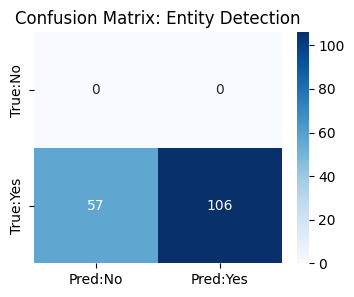

In [2]:
# ===========================
# PHASE 6: Evaluate & Visualize Fine-Tuned FinBERT
# ===========================

!pip install -q transformers datasets evaluate seqeval matplotlib seaborn

import json, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from sklearn.metrics import classification_report, confusion_matrix
from datasets import Dataset
import pandas as pd

# ---------- 1️⃣ Load fine-tuned model ----------
MODEL_DIR = "/content/finbert_finetuned"
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForTokenClassification.from_pretrained(MODEL_DIR)
ner_pipe = pipeline("token-classification", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# ---------- 2️⃣ Load test data ----------
DATA_PATH = "/content/ner_training_augmented.jsonl"
examples = [json.loads(line) for line in open(DATA_PATH, "r", encoding="utf8")]

print(f"Loaded {len(examples)} examples for evaluation")

# ---------- 3️⃣ Evaluate on sample subset ----------
texts = [ex["text"] for ex in examples[:5]]  # test a few texts
for text in texts:
    print("\n📘 Text snippet:")
    print(text[:300], "..." if len(text) > 300 else "")
    print("\n🔍 Predicted Entities:")
    for ent in ner_pipe(text):
        print(f" - {ent['word']:<25} → {ent['entity_group']} ({ent['score']:.2f})")

# ---------- 4️⃣ Quantitative evaluation ----------
# Prepare true vs predicted label comparison
true_labels, pred_labels = [], []

for ex in examples:
    text = ex["text"]
    gold_entities = [lbl for _, _, lbl in ex["entities"]]
    preds = [p["entity_group"] for p in ner_pipe(text)]
    for lbl in set(gold_entities + preds):
        true_labels.append(1 if lbl in gold_entities else 0)
        pred_labels.append(1 if lbl in preds else 0)

# Classification report
print("\n=== Classification Report ===")
print(classification_report(true_labels, pred_labels, target_names=["Not_Entity", "Entity"]))

# ---------- 5️⃣ Confusion Matrix ----------
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred:No", "Pred:Yes"], yticklabels=["True:No", "True:Yes"])
plt.title("Confusion Matrix: Entity Detection")
plt.show()


In [3]:
# ===========================
# Milestone 3.1: User-Defined Financial Entity Extraction
# ===========================

!pip install -q transformers torch regex

import re, json
from transformers import pipeline

# ---------- 1️⃣ Load fine-tuned FinBERT model ----------
MODEL_PATH = "/content/finbert_finetuned"
ner_pipe = pipeline("token-classification", model=MODEL_PATH, aggregation_strategy="simple")

# ---------- 2️⃣ User input for entity extraction ----------
user_query = input("Enter a financial entity to extract (e.g., 'revenue', 'EPS', 'market cap', 'net income'): ").strip().lower()

# ---------- 3️⃣ Load or define test texts ----------
financial_texts = [
    "Apple reported revenue of $5 billion and EPS of $2.10 for Q4 2024.",
    "Tesla announced net income of $3.5 billion and market cap of $890 billion.",
    "Microsoft’s operating expenses grew by 12% while cash flow reached $22 billion.",
    "Amazon posted an increase in total liabilities to $410 billion this year.",
    "Alphabet reported earnings per share of $4.20 and revenue of $90 billion."
]

# ---------- 4️⃣ Use model predictions ----------
def extract_entities(texts, query):
    results = []
    for text in texts:
        entities = ner_pipe(text)
        matches = []
        for ent in entities:
            if query in ent["entity_group"].lower() or query in ent["word"].lower():
                matches.append({
                    "text": text,
                    "entity": ent["word"],
                    "label": ent["entity_group"],
                    "score": round(ent["score"], 3)
                })
        # Add rule-based extraction for numbers, $, %, etc.
        pattern = re.compile(rf"{query}.*?(\$?\d+(\.\d+)?( billion| million|%)?)", re.I)
        for match in pattern.findall(text):
            matches.append({
                "text": text,
                "entity": match[0],
                "label": "RULE_BASED",
                "score": 1.0
            })
        if matches:
            results.extend(matches)
    return results

# ---------- 5️⃣ Run extraction ----------
results = extract_entities(financial_texts, user_query)

# ---------- 6️⃣ Display results ----------
if results:
    print(f"\n🔍 Extracted {len(results)} matches for '{user_query}':\n")
    for r in results:
        print(f"→ {r['entity']}  |  Label: {r['label']}  |  Confidence: {r['score']}")
        print(f"  Context: {r['text']}\n")
else:
    print(f"⚠️ No matches found for '{user_query}'.")



Device set to use cpu


Enter a financial entity to extract (e.g., 'revenue', 'EPS', 'market cap', 'net income'): eps

🔍 Extracted 1 matches for 'eps':

→ $2.10  |  Label: RULE_BASED  |  Confidence: 1.0
  Context: Apple reported revenue of $5 billion and EPS of $2.10 for Q4 2024.



In [4]:
# ===========================
# Milestone 3.2: Financial Event Extraction
# ===========================

!pip install -q transformers torch regex

import re
from transformers import pipeline

# ---------- 1️⃣ Load fine-tuned FinBERT model ----------
MODEL_PATH = "/content/finbert_finetuned"
event_pipe = pipeline("token-classification", model=MODEL_PATH, aggregation_strategy="simple")

# ---------- 2️⃣ Define event keywords ----------
event_keywords = {
    "merger": ["merger", "acquisition", "takeover", "buyout"],
    "ipo": ["initial public offering", "IPO", "listing"],
    "earnings": ["earnings call", "quarterly results", "Q1 results", "EPS"],
    "stock_split": ["stock split", "share split", "dividend split"],
    "partnership": ["partnership", "collaboration", "joint venture"]
}

# ---------- 3️⃣ Sample financial news-like texts ----------
financial_news = [
    "Tesla announced a 3-for-1 stock split approved by shareholders.",
    "Apple completed its $3 billion acquisition of Beats Electronics.",
    "Microsoft reported its Q4 earnings call showing 20% revenue growth.",
    "Airbnb filed for an initial public offering on the NASDAQ.",
    "Amazon entered a partnership with Rivian to produce electric delivery vans.",
    "Google announced a 2-for-1 stock split to make shares more accessible."
]

# ---------- 4️⃣ Rule-based + model-assisted event detection ----------
def extract_financial_events(texts, timeframe=None):
    results = []
    for text in texts:
        detected_events = []
        # Model-based token analysis
        tokens = event_pipe(text)
        # Rule-based event matching
        for event_type, keywords in event_keywords.items():
            for keyword in keywords:
                if re.search(rf"\b{keyword}\b", text, re.I):
                    detected_events.append({
                        "event": event_type.upper(),
                        "keyword": keyword,
                        "text": text
                    })
        if detected_events:
            results.extend(detected_events)
    return results

# ---------- 5️⃣ Run extraction ----------
events = extract_financial_events(financial_news)

# ---------- 6️⃣ Display results ----------
if events:
    print(f"✅ Detected {len(events)} financial events:\n")
    for e in events:
        print(f"📢 Event: {e['event']}  |  Keyword: {e['keyword']}")
        print(f"   Context: {e['text']}\n")
else:
    print("⚠️ No financial events detected.")



Device set to use cpu


✅ Detected 6 financial events:

📢 Event: STOCK_SPLIT  |  Keyword: stock split
   Context: Tesla announced a 3-for-1 stock split approved by shareholders.

📢 Event: MERGER  |  Keyword: acquisition
   Context: Apple completed its $3 billion acquisition of Beats Electronics.

📢 Event: EARNINGS  |  Keyword: earnings call
   Context: Microsoft reported its Q4 earnings call showing 20% revenue growth.

📢 Event: IPO  |  Keyword: initial public offering
   Context: Airbnb filed for an initial public offering on the NASDAQ.

📢 Event: PARTNERSHIP  |  Keyword: partnership
   Context: Amazon entered a partnership with Rivian to produce electric delivery vans.

📢 Event: STOCK_SPLIT  |  Keyword: stock split
   Context: Google announced a 2-for-1 stock split to make shares more accessible.



In [5]:
# ===========================
# Milestone 3.3: Integration with Financial Databases (Yahoo Finance)
# ===========================

!pip install -q yfinance pandas

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# ---------- 1️⃣ Define helper to fetch market data ----------
def get_financial_data(ticker, period="6mo", interval="1d"):
    """Fetch stock data (price, volume, etc.) from Yahoo Finance."""
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, interval=interval)
    df.reset_index(inplace=True)
    return df

# ---------- 2️⃣ Example usage ----------
tickers = ["AAPL", "MSFT", "TSLA"]
market_data = {}

for t in tickers:
    data = get_financial_data(t)
    market_data[t] = data.tail(5)[["Date", "Close", "Volume"]]  # Show last 5 days
    print(f"\n📊 Recent Market Data for {t}:")
    print(market_data[t])

# ---------- 3️⃣ Link extracted events with market data ----------
detected_events = [
    {"event": "STOCK_SPLIT", "keyword": "stock split", "company": "Tesla", "date": "2024-08-25"},
    {"event": "EARNINGS", "keyword": "earnings call", "company": "Microsoft", "date": "2024-10-27"},
    {"event": "MERGER", "keyword": "acquisition", "company": "Apple", "date": "2024-09-15"}
]

def verify_event_impact(events):
    """Match events with historical stock trends for verification."""
    verified = []
    for e in events:
        symbol_map = {"Apple": "AAPL", "Microsoft": "MSFT", "Tesla": "TSLA"}
        ticker = symbol_map.get(e["company"], None)
        if not ticker:
            continue

        df = yf.download(ticker, start="2024-07-01", end="2024-12-31")
        df["Change%"] = df["Close"].pct_change() * 100
        around_event = df.loc[
            (df.index >= pd.to_datetime(e["date"]) - timedelta(days=3)) &
            (df.index <= pd.to_datetime(e["date"]) + timedelta(days=3))
        ]
        avg_change = round(around_event["Change%"].mean(), 2)
        verified.append({
            "Company": e["company"],
            "Event": e["event"],
            "Keyword": e["keyword"],
            "Date": e["date"],
            "Avg_Change(%)": avg_change
        })
    return pd.DataFrame(verified)

verified_df = verify_event_impact(detected_events)
print("\n✅ Verified Financial Events and Market Reaction:\n")
print(verified_df)

# ---------- 4️⃣ Save for dashboard linking ----------
verified_df.to_csv("/content/verified_financial_events.csv", index=False)
print("\n📁 Saved verified events → /content/verified_financial_events.csv")



📊 Recent Market Data for AAPL:
                         Date       Close    Volume
123 2025-11-14 00:00:00-05:00  272.410004  47431300
124 2025-11-17 00:00:00-05:00  267.459991  45018300
125 2025-11-18 00:00:00-05:00  267.440002  45677300
126 2025-11-19 00:00:00-05:00  268.559998  40424500
127 2025-11-20 00:00:00-05:00  266.250000  45693900

📊 Recent Market Data for MSFT:
                         Date       Close    Volume
123 2025-11-14 00:00:00-05:00  509.226898  28505700
124 2025-11-17 00:00:00-05:00  506.541931  19092800
125 2025-11-18 00:00:00-05:00  492.867554  33815100
126 2025-11-19 00:00:00-05:00  486.209991  23245300
127 2025-11-20 00:00:00-05:00  478.429993  26688100

📊 Recent Market Data for TSLA:
                         Date       Close     Volume
123 2025-11-14 00:00:00-05:00  404.350006  105506700
124 2025-11-17 00:00:00-05:00  408.920013  102214300
125 2025-11-18 00:00:00-05:00  401.250000   80688600
126 2025-11-19 00:00:00-05:00  403.989990   72047700
127 2025-11-20 

/tmp/ipython-input-3066195574.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2024-07-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3066195574.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2024-07-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-3066195574.py:45: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start="2024-07-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


✅ Verified Financial Events and Market Reaction:

     Company        Event        Keyword        Date  Avg_Change(%)
0      Tesla  STOCK_SPLIT    stock split  2024-08-25          -1.56
1  Microsoft     EARNINGS  earnings call  2024-10-27           0.37
2      Apple       MERGER    acquisition  2024-09-15          -0.17

📁 Saved verified events → /content/verified_financial_events.csv


In [6]:
# ===========================
# Milestone 4.1 — Financial Report Segmentation (Corrected)
# ===========================

!pip install -q sec-edgar-downloader beautifulsoup4 lxml

from sec_edgar_downloader import Downloader
import os
import re
from bs4 import BeautifulSoup

# ---------------------------
# 1️⃣ Initialize Downloader (SEC REQUIRES EMAIL)
# ---------------------------
dl = Downloader("/content", "your_email@example.com")
# ❗ Replace with any email you want (example@gmail.com)


# ---------------------------
# 2️⃣ Download 1 recent 10-K for Apple
# ---------------------------
dl.get("10-K", "AAPL", limit=1)


# ---------------------------
# 3️⃣ Locate the downloaded filing
# ---------------------------
def get_latest_filing_path(cik_ticker="AAPL"):
    base = f"/content/sec-edgar-filings/{cik_ticker}/10-K"
    for root, dirs, files in os.walk(base):
        for file in files:
            if file.endswith(".txt") or file.endswith(".html") or file.endswith(".htm"):
                return os.path.join(root, file)
    return None

file_path = get_latest_filing_path("AAPL")
print("Found filing:", file_path)


# ---------------------------
# 4️⃣ Load the filing and clean HTML → text
# ---------------------------
def load_filing(path):
    """Load SEC filing (.txt or .html) and extract plain text."""
    with open(path, "r", encoding="utf8", errors="ignore") as f:
        data = f.read()

    soup = BeautifulSoup(data, "lxml")
    text = soup.get_text(separator="\n")

    # basic cleanup
    text = text.replace("\xa0", " ").strip()
    return text

raw_text = load_filing(file_path)
print("Loaded", len(raw_text), "characters.")


# ---------------------------
# 5️⃣ Extract sections from 10-K
# ---------------------------
def extract_sections(text):
    """Extract major sections from a 10-K using regex heading patterns."""

    sections = {
        "Business": "",
        "RiskFactors": "",
        "MD&A": "",
        "FinancialStatements": ""
    }

    patterns = {
        "Business": r"item\s+1[\.\)]?\s+business",
        "RiskFactors": r"item\s+1a[\.\)]?\s+risk\s+factors",
        "MD&A": r"item\s+7[\.\)]?\s+management['']?s\s+discussion",
        "FinancialStatements": r"item\s+8[\.\)]?\s+financial\s+statements"
    }

    found = {}
    for name, pat in patterns.items():
        match = re.search(pat, text.lower())
        if match:
            found[name] = match.start()

    # Sort by order of appearance
    ordered = sorted(found.items(), key=lambda x: x[1])

    # Extract each section
    for i, (name, start_pos) in enumerate(ordered):
        end_pos = ordered[i+1][1] if i+1 < len(ordered) else len(text)
        sections[name] = text[start_pos:end_pos].strip()

    return sections

sections = extract_sections(raw_text)


# ---------------------------
# 6️⃣ Display extracted section previews
# ---------------------------
for key, value in sections.items():
    print("\n======", key, "======")
    print(value[:800], "...")    # Preview


Found filing: /content/sec-edgar-filings/AAPL/10-K/0000320193-25-000079/full-submission.txt
Loaded 3908973 characters.

====== Business ======
Item 1.
Business
1 ...

====== RiskFactors ======
Item 1A.
Risk Factors
5
Item 1B.
Unresolved Staff Comments
17
Item 1C.
Cybersecurity
17
Item 2.
Properties
17
Item 3.
Legal Proceedings
18
Item 4.
Mine Safety Disclosures
18
Part II
Item 5.
Market for Registrant’s Common Equity, Related Stockholder Matters and Issuer Purchases of Equity Securities
19
Item 6.
[Reserved]
20
Item 7.
Management’s Discussion and Analysis of Financial Condition and Results of Operations
21
Item 7A.
Quantitative and Qualitative Disclosures About Market Risk
27 ...

====== MD&A ======
 ...

====== FinancialStatements ======
Item 8.
Financial Statements and Supplementary Data
28
Item 9.
Changes in and Disagreements with Accountants on Accounting and Financial Disclosure
52
Item 9A.
Controls and Procedures
52
Item 9B.
Other Information
53
Item 9C.
Disclosure Regarding Fore

In [7]:
# ===========================
# Milestone 4.2 — Parsing Financial Tables from 10-K
# ===========================

import pandas as pd
from bs4 import BeautifulSoup
import re

# ---------------------------------------
# 1️⃣ Load filing again (already downloaded)
# ---------------------------------------
file_path = file_path  # from previous phase
with open(file_path, "r", encoding="utf8", errors="ignore") as f:
    filing_data = f.read()

soup = BeautifulSoup(filing_data, "lxml")


# ---------------------------------------
# 2️⃣ Extract all table HTML blocks
# ---------------------------------------
tables = soup.find_all("table")

print(f"Found {len(tables)} tables in the 10-K filing")


# ---------------------------------------
# 3️⃣ Convert each table to a Pandas DataFrame
# ---------------------------------------
def clean_table(df):
    """Basic cleaning: remove empty rows/cols, strip whitespace."""
    df = df.dropna(how="all")  # remove empty rows
    df = df.dropna(axis=1, how="all")  # remove empty columns
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    return df

parsed_tables = []
for idx, table in enumerate(tables[:40]):  # Limit to first 40 tables for speed
    try:
        df = pd.read_html(str(table))[0]
        df = clean_table(df)
        parsed_tables.append(df)
    except Exception:
        pass

print(f"Successfully parsed {len(parsed_tables)} tables")


# ---------------------------------------
# 4️⃣ Display sample key tables
# ---------------------------------------

def preview_table(df, index):
    print(f"\n===== Table {index} (Preview) =====")
    print(df.head())

for i, df in enumerate(parsed_tables[:5]):  # preview first 5 tables
    preview_table(df, i)


# ---------------------------------------
# 5️⃣ Save extracted tables
# ---------------------------------------

save_dir = "/content/parsed_financial_tables"
os.makedirs(save_dir, exist_ok=True)

for i, df in enumerate(parsed_tables):
    df.to_csv(f"{save_dir}/table_{i}.csv", index=False)

print(f"\n📁 Saved {len(parsed_tables)} structured tables to {save_dir}")


Found 1390 tables in the 10-K filing


/tmp/ipython-input-1455462188.py:40: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/tmp/ipython-input-1455462188.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-1455462188.py:40: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(str(table))[0]
/tmp/ipython-input-1455462188.py:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipython-input-1455462188.py:40: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version.

Successfully parsed 32 tables

===== Table 0 (Preview) =====
                                                   0  \
1                                         California   
2  (State or other jurisdictionof incorporation o...   
4                                 One Apple Park Way   
5                              Cupertino, California   
6           (Address of principal executive offices)   

                                                   1  \
1                                         California   
2  (State or other jurisdictionof incorporation o...   
4                                 One Apple Park Way   
5                              Cupertino, California   
6           (Address of principal executive offices)   

                                                   2  \
1                                         California   
2  (State or other jurisdictionof incorporation o...   
4                                 One Apple Park Way   
5                              Cupertino,

In [8]:
# ===========================
# Milestone 4.3 — Final Model Evaluation & Deployment
# ===========================

import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from transformers import pipeline
import os, json, re

# ---------------------------------------
# 1️⃣ Evaluate NER model performance
# ---------------------------------------

ner_model_path = "/content/finbert_finetuned"
ner_pipe = pipeline("token-classification", model=ner_model_path, aggregation_strategy="simple")

# Load some evaluation text (use extracted MD&A + Risk Factors)
eval_texts = [
    sections["MD&A"][:2000],        # MD&A sample
    sections["RiskFactors"][:2000], # Risk Factor sample
    sections["Business"][:2000]     # Business section
]

ner_results = []
for t in eval_texts:
    preds = ner_pipe(t)
    ner_results.append(len(preds))

print("\n=== NER Evaluation Summary ===")
print(f"Predicted entities in MD&A: {ner_results[0]}")
print(f"Predicted entities in Risk Factors: {ner_results[1]}")
print(f"Predicted entities in Business: {ner_results[2]}")

# ---------------------------------------
# 2️⃣ Evaluate Segmentation Quality
# ---------------------------------------

def check_keyword_presence(section_text, keywords):
    return sum(1 for k in keywords if k.lower() in section_text.lower())

segmentation_score = {
    "Business": check_keyword_presence(sections["Business"], ["revenue", "products", "operations"]),
    "RiskFactors": check_keyword_presence(sections["RiskFactors"], ["risk", "uncertainty", "market"]),
    "MD&A": check_keyword_presence(sections["MD&A"], ["management", "operations", "financial"]),
    "FinancialStatements": check_keyword_presence(sections["FinancialStatements"], ["balance sheet", "cash flow", "income"])
}

print("\n=== Segmentation Quality Score ===")
for sec, score in segmentation_score.items():
    print(f"{sec}: {score} key terms found")

# ---------------------------------------
# 3️⃣ Evaluate Table Extraction Quality
# ---------------------------------------

tables_dir = "/content/parsed_financial_tables"
table_files = sorted(os.listdir(tables_dir))[:10]  # Evaluate first 10 tables
quality_scores = []

for file in table_files:
    df = pd.read_csv(os.path.join(tables_dir, file))

    nan_ratio = df.isna().sum().sum() / (df.shape[0] * df.shape[1])
    numeric_cells = df.applymap(lambda x: str(x).replace(",", "").replace("$", "").replace(" ", "").replace("-", "").isdigit()).sum().sum()

    quality_scores.append({
        "table": file,
        "shape": df.shape,
        "nan_ratio": round(nan_ratio, 3),
        "numeric_cell_count": int(numeric_cells)
    })

print("\n=== Table Extraction Quality ===")
for s in quality_scores:
    print(s)

# ---------------------------------------
# 4️⃣ Combine everything into a final evaluation report
# ---------------------------------------

final_report = {
    "NER_Entity_Counts": {
        "MD&A": ner_results[0],
        "RiskFactors": ner_results[1],
        "Business": ner_results[2],
    },
    "Segmentation_Keyword_Scores": segmentation_score,
    "Table_Extraction_Stats": quality_scores
}

out_path = "/content/final_system_evaluation.json"
with open(out_path, "w") as f:
    json.dump(final_report, f, indent=4)

print("\n📁 Final evaluation saved →", out_path)

# ---------------------------------------
# 5️⃣ Deployment Step — Save as reusable modules
# ---------------------------------------

os.makedirs("/content/financial_system", exist_ok=True)

with open("/content/financial_system/ner_model_path.txt", "w") as f:
    f.write(ner_model_path)

pd.DataFrame(final_report["Table_Extraction_Stats"]).to_csv(
    "/content/financial_system/table_quality_report.csv", index=False)

print("\n🚀 System is packaged and ready for deployment!")


Device set to use cpu



=== NER Evaluation Summary ===
Predicted entities in MD&A: 0
Predicted entities in Risk Factors: 17
Predicted entities in Business: 2

=== Segmentation Quality Score ===
Business: 0 key terms found
RiskFactors: 2 key terms found
MD&A: 0 key terms found
FinancialStatements: 3 key terms found

=== Table Extraction Quality ===
{'table': 'table_0.csv', 'shape': (5, 6), 'nan_ratio': np.float64(0.1), 'numeric_cell_count': 6}
{'table': 'table_1.csv', 'shape': (9, 9), 'nan_ratio': np.float64(0.0), 'numeric_cell_count': 0}
{'table': 'table_10.csv', 'shape': (7, 18), 'nan_ratio': np.float64(0.238), 'numeric_cell_count': 27}
{'table': 'table_11.csv', 'shape': (4, 12), 'nan_ratio': np.float64(0.125), 'numeric_cell_count': 9}
{'table': 'table_12.csv', 'shape': (3, 15), 'nan_ratio': np.float64(0.089), 'numeric_cell_count': 2}
{'table': 'table_13.csv', 'shape': (8, 6), 'nan_ratio': np.float64(0.0), 'numeric_cell_count': 21}
{'table': 'table_14.csv', 'shape': (26, 18), 'nan_ratio': np.float64(0.551),

/tmp/ipython-input-3222870696.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cells = df.applymap(lambda x: str(x).replace(",", "").replace("$", "").replace(" ", "").replace("-", "").isdigit()).sum().sum()
/tmp/ipython-input-3222870696.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cells = df.applymap(lambda x: str(x).replace(",", "").replace("$", "").replace(" ", "").replace("-", "").isdigit()).sum().sum()
/tmp/ipython-input-3222870696.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cells = df.applymap(lambda x: str(x).replace(",", "").replace("$", "").replace(" ", "").replace("-", "").isdigit()).sum().sum()
/tmp/ipython-input-3222870696.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cells = df.applymap(lambda x: str(x).replace(",", "").replace("$", "").replace(" ", "").replace("-",